In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
import seaborn as sns

In [2]:
ladf = pd.read_csv('data/ladf.csv')

In [3]:
layr = ladf.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)

In [4]:
X = ladf.drop(['Year', 'Month', 'zipcode'], axis=1).values
scaler = MinMaxScaler()
X_sca = scaler.fit_transform(X)
model = KMeans(5, n_init=3)
model.fit(X)
labels = model.labels_
centroids = model.cluster_centers_ 
ladf['class'] = labels
cntClass = ladf.groupby(['Year', 'Month', 'class'])['zipcode'].count().unstack().reset_index()


In [5]:
X_test = cntClass.drop(['Year', 'Month'], axis=1).values

In [6]:
X_test = 1.0 * X_test / X_test.sum(axis =1).reshape(-1, 1)

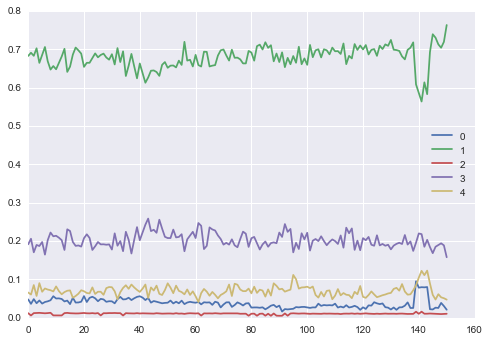

In [7]:
plt.figure()
for k in xrange(5):
    plt.plot(X_test[:,k], label= k)
plt.legend(loc='best')
plt.show()

In [8]:
layr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3813 entries, 0 to 3812
Data columns (total 12 columns):
Year       3813 non-null int64
zipcode    3813 non-null int64
1          3813 non-null float64
2          3813 non-null float64
3          3813 non-null float64
4          3813 non-null float64
5          3813 non-null float64
6          3813 non-null float64
7          3813 non-null float64
8          3813 non-null float64
9          3813 non-null float64
10         3813 non-null float64
dtypes: float64(10), int64(2)
memory usage: 357.5 KB


In [25]:
def nmf_test(df, scale=True):
    X = df.drop(['Year', 'zipcode'], axis=1).values
    if scale:
        scaler = MinMaxScaler()
        X_sca = scaler.fit_transform(X)
    scores = []
    for k in xrange(2, 11):
        model = NMF(n_components=k)
        W = model.fit_transform(X)
        labels = W.argmax(axis=1)
        score = silhouette_score(X, labels)
        scores.append(score)
    plt.plot(xrange(2, 11), scores, 'b*-')
    plt.show()


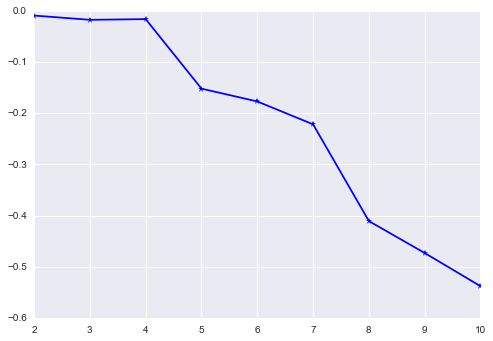

In [10]:
nmf_test(layr)

In [11]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary', 8: 'Homicide', 9: 'Sex Crime', 10: 'DUI'}

def nmf_pipline(df):
    numPost = df['zipcode'].unique().shape[0]
    X = df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    model = NMF(n_components=5)
    W = model.fit_transform(X_sca)
    labels = W.argmax(axis=1)
    H = model.components_
    df['class'] = labels
    cntClass = df.groupby(['Year', 'class'])['zipcode'].count().unstack().reset_index()
    X_class = cntClass.drop(['Year'], axis=1).values
    X_class = 1.0 * X_class/ numPost
    years = sorted(df['Year'].unique())
    className = ['cls -{}'.format(k+1) for k in xrange(5)]
    plot_heatmap(H.T)
    plot_lines(X_class, years, className)
    plot_bars(X_class, years, className)
    plt.show()
    return model, df

def plot_bars(data, years, className):    
    pd.DataFrame(data, columns=className).plot.bar(stacked=True)
    plt.xticks(range(len(years)), years)

def plot_lines(data, years, className):
    plt.figure()
    for k in xrange(5):
        plt.plot(years, data[:,k], label=className[k])
    plt.legend(loc='best')
    
def plot_heatmap(data):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(5)+0.5, minor=False, )
    ax.set_yticks(np.arange(10)+0.5, minor=False)

    # want a more natural, table-like display
#     ax.invert_yaxis()
#     ax.xaxis.tick_top()
    classLabel = ['cls-{}:'.format(i) for i in range(1, 6)]
    ax.set_xticklabels(classLabel, minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()
    

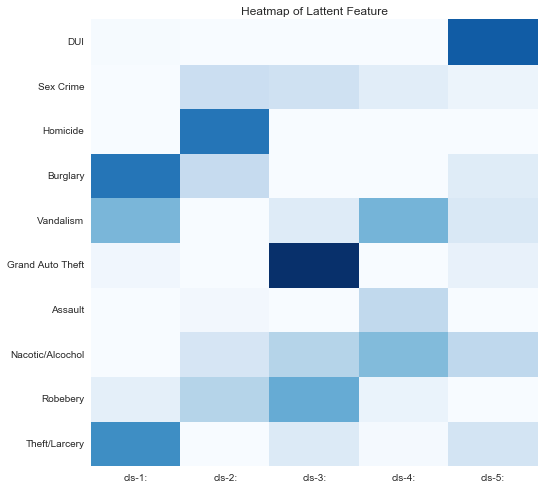

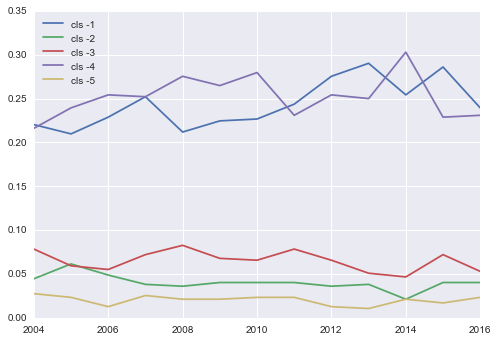

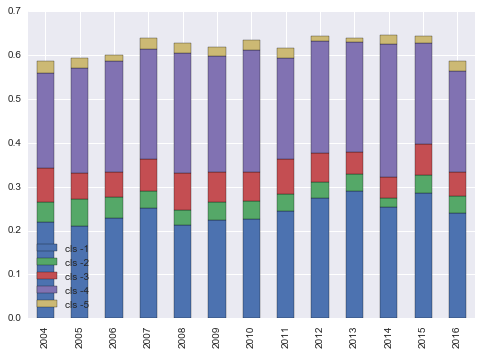

In [12]:
nmf = nmf_pipline(layr)

In [13]:
layr.head()

,Year,zipcode,1,2,3,4,5,6,7,8,9,10,class
0,2004,90000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2
1,2004,90001,85.0,45.0,77.0,109.0,120.0,28.0,90.0,6.0,19.0,1.0,1
2,2004,90002,12.0,15.0,12.0,19.0,19.0,5.0,15.0,2.0,2.0,0.0,1
3,2004,90003,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1
4,2004,90004,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3


In [14]:
phdf = pd.read_csv('data/phdf.csv')
sfdf = pd.read_csv('data/sfdf.csv')
louisdf = pd.read_csv('data/louisdf.csv')
dedf = pd.read_csv('data/dedf.csv')
ladf = pd.read_csv('data/ladf.csv')

In [15]:
sfdf['8'] = 0.0
sfdf = sfdf[['Year', 'Month', 'zipcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]

In [16]:
def get_year_data(df):
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    new_df = get_scaled(new_df)
    return new_df

def get_scaled(df):
    cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    X = df[cols].values
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    df[cols] = X_sca
    return df

In [17]:
frames = [ladf, sfdf, phdf, louisdf, dedf]
for idx, df in enumerate(frames):
    frames[idx] = get_year_data(df)

In [18]:
totdf = pd.concat(frames)

In [19]:
totdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6065 entries, 0 to 582
Data columns (total 12 columns):
Year       6065 non-null int64
zipcode    6065 non-null object
1          6065 non-null float64
2          6065 non-null float64
3          6065 non-null float64
4          6065 non-null float64
5          6065 non-null float64
6          6065 non-null float64
7          6065 non-null float64
8          6065 non-null float64
9          6065 non-null float64
10         6065 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 616.0+ KB


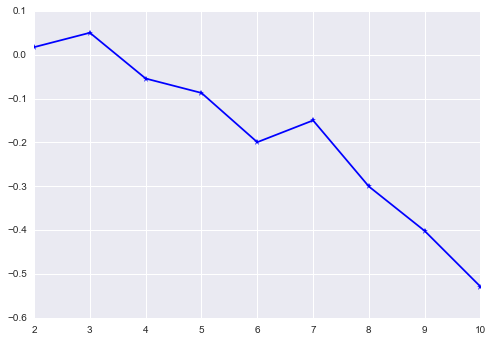

In [26]:
nmf_test(totdf)

In [23]:
def nmf_model(df, k=5):
    numPost = df['zipcode'].unique().shape[0]
    X = df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    model = NMF(n_components=k)
    W = model.fit_transform(X_sca)
    labels = W.argmax(axis=1)
    H = model.components_
    plot_heatmap(H.T)
    return model, df


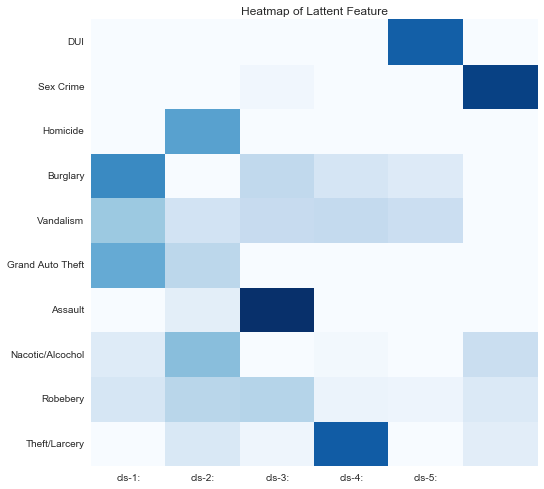

In [27]:
nmfModel = nmf_model(totdf, 6)

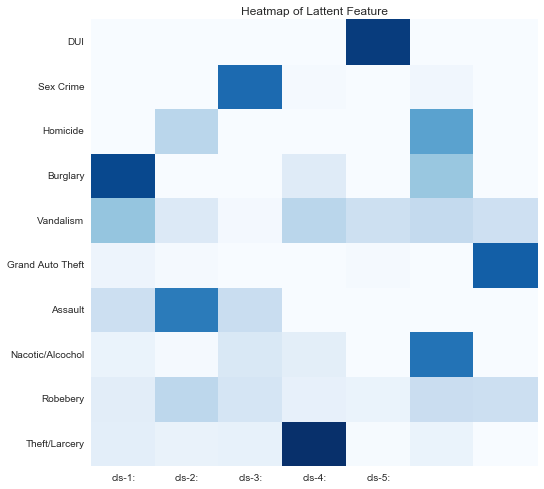

In [28]:
nmfModel = nmf_model(totdf, 7)